In [2]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

%matplotlib inline
plt.rcParams['image.cmap'] = 'Paired'
#sns.set(font_scale=2)

In [20]:
# Parent directory for the results of this run
group_results_directory = '/data/jpetrie/MEOPAR/SalishSea/results/remin_param_sweep_new_depth/'
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'
mesh_mask_file = 'mesh_mask.nc'
individual_directories = []
param_vals = []
for file in os.listdir(group_results_directory):
    if file.startswith("nampisrem_zz_remin_D_DON_"):
        if os.path.isfile(group_results_directory + file + '/' + tracer_file):
            val = float(file.split("nampisrem_zz_remin_D_DON_")[1])
            individual_directories.append(file)
            param_vals.append(val)
        else:
            print(group_results_directory + file + tracer_file)

tracer_datasets = [xr.open_dataset(group_results_directory + '/' + file +'/' + tracer_file) for file in individual_directories]
dataset_dict = dict(zip(param_vals, tracer_datasets))

In [27]:
depths = dataset_dict[param_vals[0]].deptht.values

min_depth_index = np.argmax(depths > 150)
max_depth_index = len(depths)

#for param in param_vals:
t = np.array([float(x) for x in dataset_dict[param_vals[0]].time_centered.values])   
days = (t[:] - t[0])/10**9/3600/24

min_day_index = np.argmax(days > 30)
max_day_index = len(days)

In [24]:
mesh_mask = xr.open_dataset(group_results_directory + individual_directories[0] + '/' + mesh_mask_file)
grid_heights = np.array(mesh_mask['e3t_1d'][0])

array([  1.00000115,   1.00000501,   1.00001253,   1.00002718,
         1.0000557 ,   1.00011125,   1.00021946,   1.0004302 ,
         1.00084067,   1.00164012,   1.0031971 ,   1.00622914,
         1.01213271,   1.02362358,   1.04597551,   1.08940061,
         1.17356428,   1.33592899,   1.64636781,   2.22990285,
         3.29248567,   5.11998508,   7.97451506,  11.8252972 ,
        16.10792044,  19.95870258,  22.81323256,  24.64073198,
        25.70331479,  26.28684983,  26.59728865,  26.75965336,
        26.84381704,  26.88724213,  26.90959407,  26.92108493,
        26.9269885 ,  26.93002054,  26.93157752,  26.93237697])

In [44]:
NO3_quantity = ((dataset_dict[param_vals[0]].NO3.values)*(grid_heights.reshape((1,40,1,1))))

In [117]:
param_metrics = pd.DataFrame({'PARAM':param_vals})

plot_tracers = ['NO3', 'DOC','NH4']

for param in param_vals:
    for tracer in plot_tracers:
        tracer_quantity_array = ((dataset_dict[param][tracer].values)*(grid_heights.reshape((1,40,1,1))))
        total_tracer = tracer_quantity_array[min_day_index:max_day_index, min_depth_index:max_depth_index,:,:].sum()
        mean_tracer = total_tracer/sum(grid_heights[min_depth_index:max_depth_index])/(max_day_index - min_day_index)/15
        param_metrics.loc[(param_metrics['PARAM'] == param), "MEAN_"+tracer] = mean_tracer
param_metrics

,PARAM,MEAN_NO3,MEAN_DOC,MEAN_NH4
0,5.777339e-08,27.284163,1.004101,0.851692
1,9.156465e-08,27.333767,0.923754,0.881030
2,3.645254e-08,27.251353,1.058807,0.830807
3,5.777339e-07,27.789168,0.304156,1.035750
4,9.156465e-07,27.936471,0.154197,1.036087
5,2.300000e-07,27.507988,0.662042,0.964413
6,1.451202e-06,28.055208,0.060200,1.009204
7,3.645254e-07,27.638845,0.485198,1.007710
8,1.451202e-07,27.406507,0.810743,0.919458
9,2.300000e-08,27.230044,1.095036,0.816584


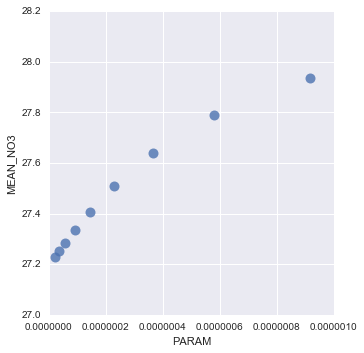

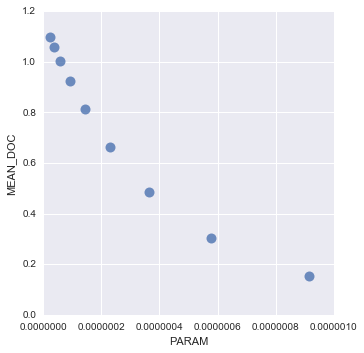

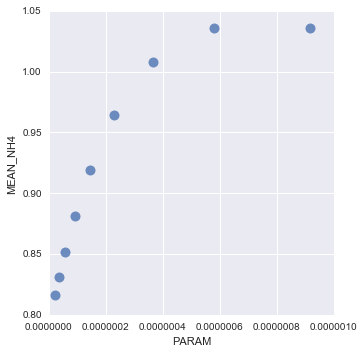

In [118]:
# Mean tracer values at depth and more than 1 month into the simulation by DON remineralization paramater

for tracer in plot_tracers:
    p = sns.lmplot('PARAM', 'MEAN_'+tracer,data=param_metrics,fit_reg=False, scatter_kws={"marker": "D",  "s": 100})
    plt.xlim(0,1e-6)

In [108]:
dataset_dict[param_vals[0]].NO3.values[30,30]

array([[  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [ 27.42627144,  27.42627144,  27.42627144,  27.42627144,
         27.42627144],
       [ 27.42420006,  27.42420006,  27.42420006,  27.42420006,
         27.42420006],
       [ 27.42217636,  27.42217636,  27.42217636,  27.42217636,
         27.42217636],
       [  0.        ,   0.        ,   0.        ,   0.        ,   0.        ]])

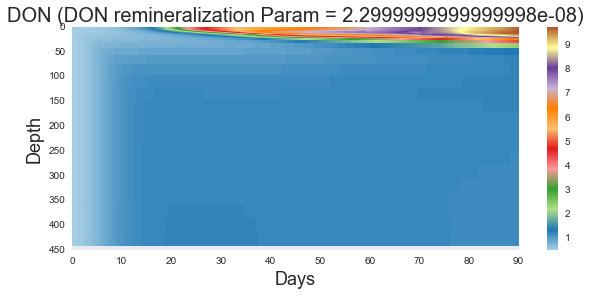

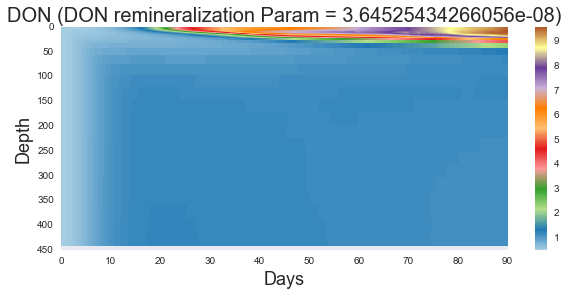

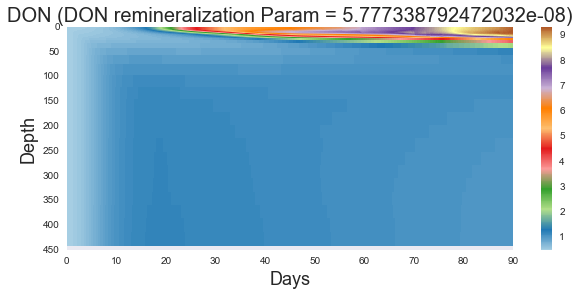

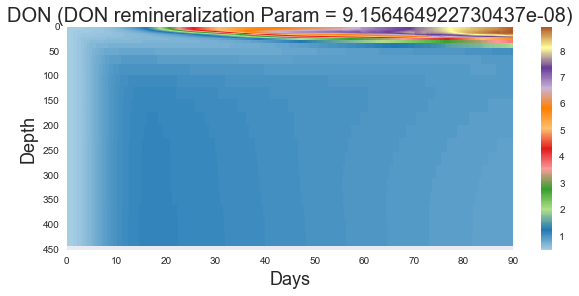

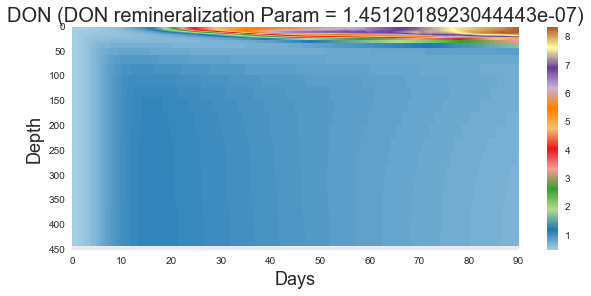

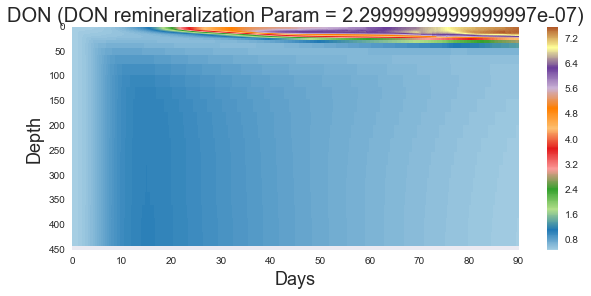

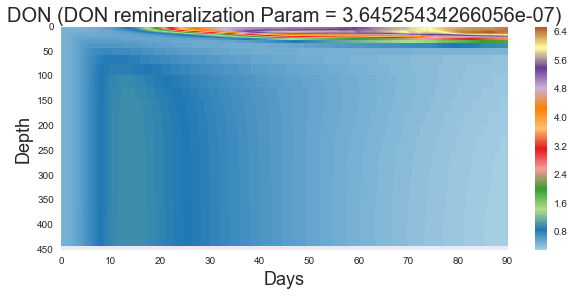

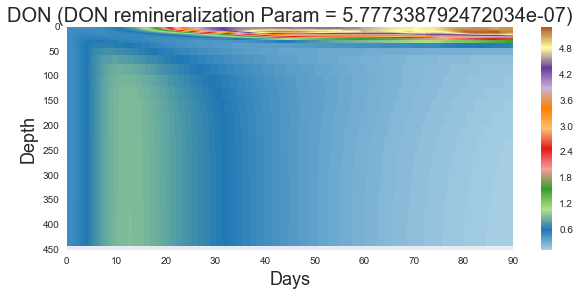

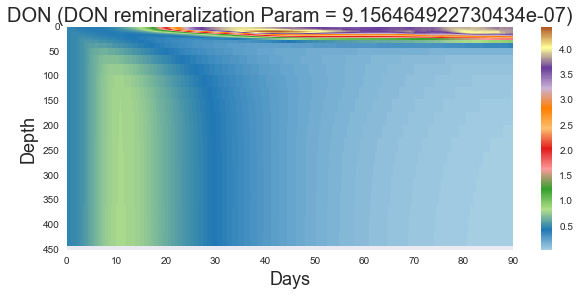

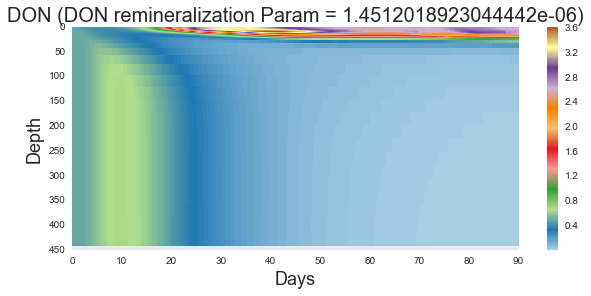

In [4]:
# Plot depth/time/DON heatmap for each value of alpha
keys = (list(dataset_dict.keys()))
keys.sort()

for DON_remin_const in keys:
    z = dataset_dict[DON_remin_const].deptht.values
    t= np.array([float(x) for x in dataset_dict[DON_remin_const].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[DON_remin_const].DOC.values[:,:,2,2].T)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title("DON (DON remineralization Param = " + str(DON_remin_const)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

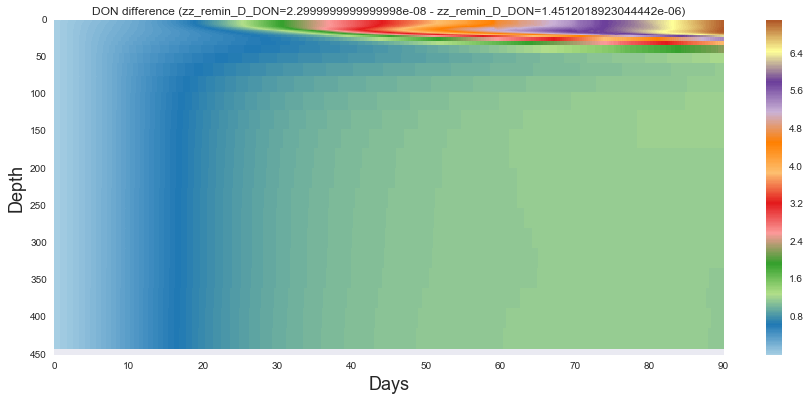

In [5]:
# Plot the difference in DON concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)
mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1].DOC.values[:,:,2,2].T - dataset_dict[param_2].DOC.values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title("DON difference (zz_remin_D_DON=" + str(param_1) + " - zz_remin_D_DON=" +str(param_2)+ ")")

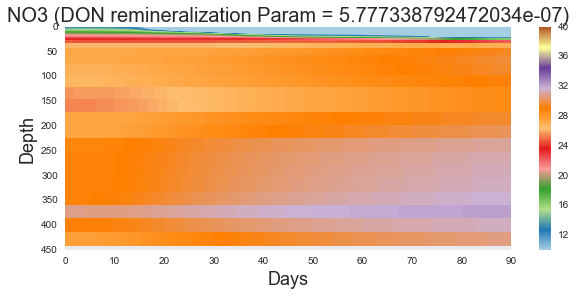

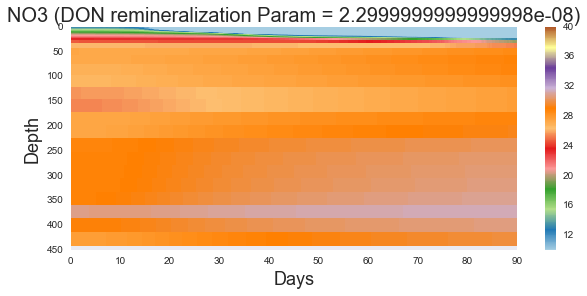

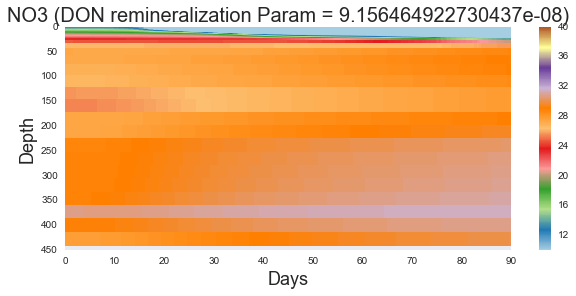

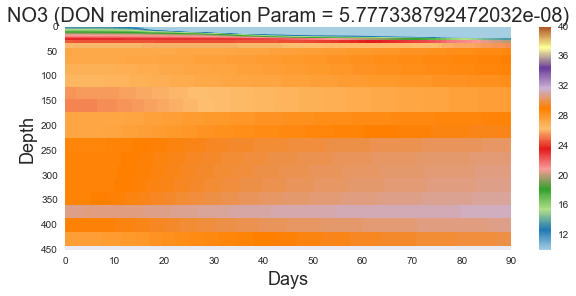

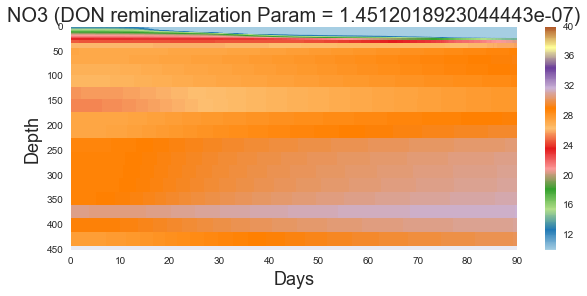

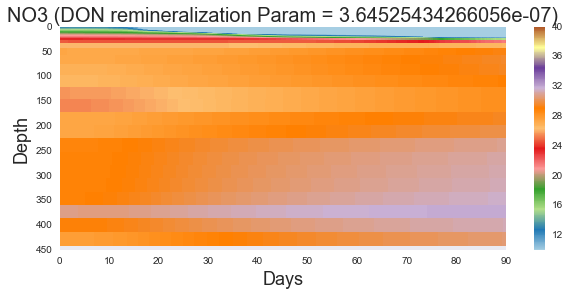

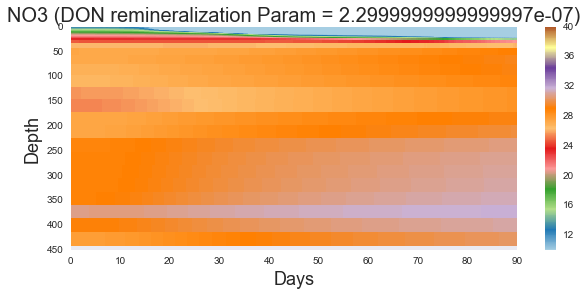

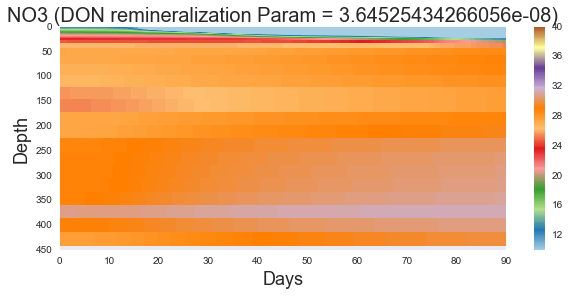

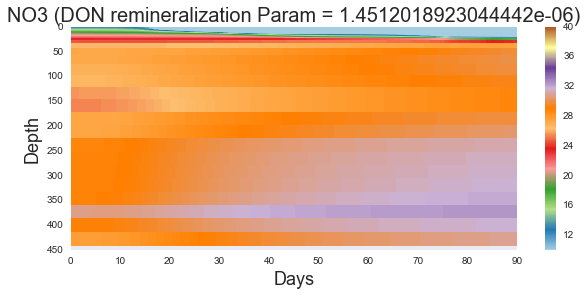

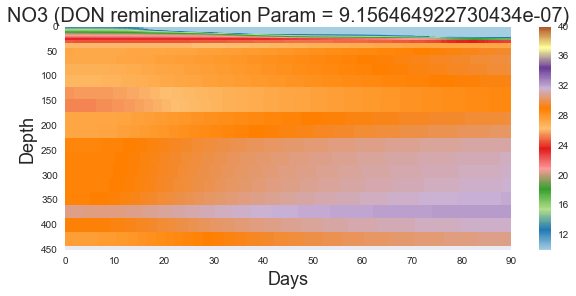

In [119]:
# Plot depth/time/NO3 heatmap for each value
for DON_remin_const in dataset_dict:
    z = dataset_dict[DON_remin_const].deptht.values
    t= np.array([float(x) for x in dataset_dict[DON_remin_const].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[DON_remin_const].NO3.values[:,:,2,2].T, vmin = 10, vmax = 40)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title("NO3 (DON remineralization Param = " + str(DON_remin_const)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

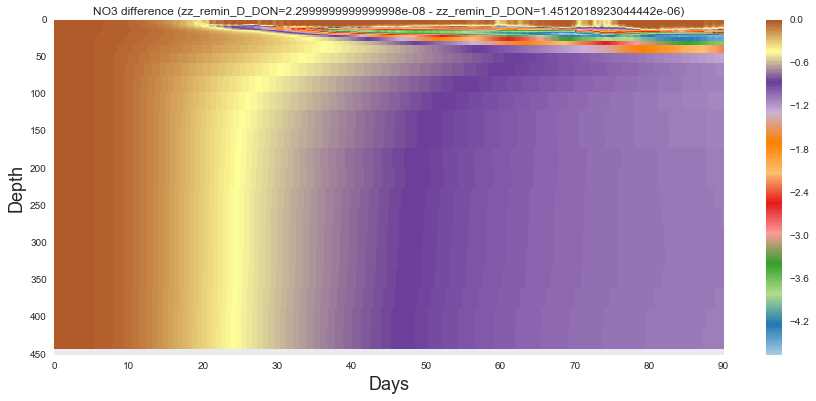

In [7]:
# Plot the difference in NO3 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1].NO3.values[:,:,2,2].T - dataset_dict[param_2].NO3.values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title("NO3 difference (zz_remin_D_DON=" + str(param_1) + " - zz_remin_D_DON=" +str(param_2)+ ")")

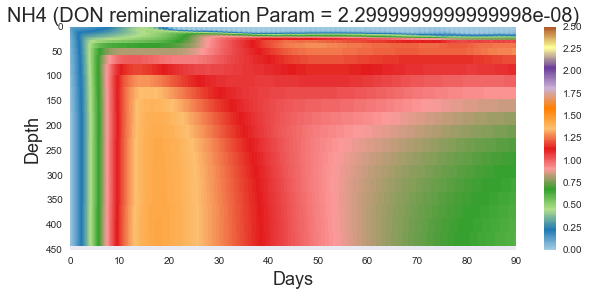

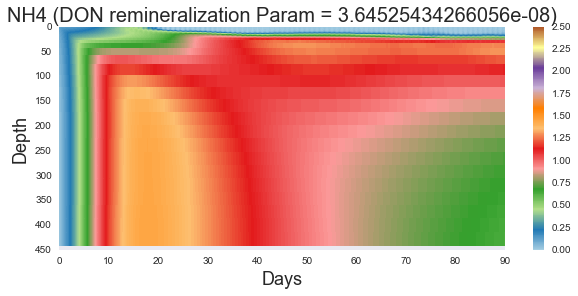

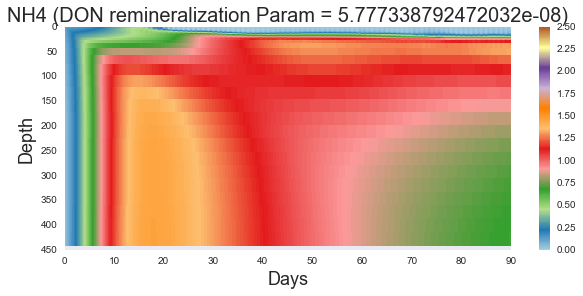

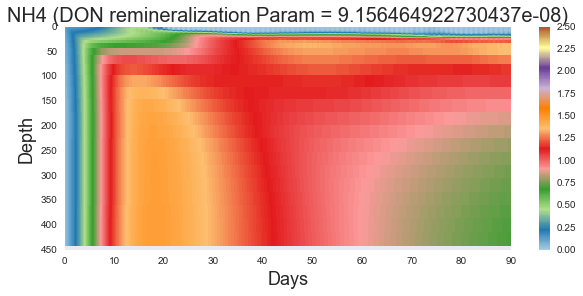

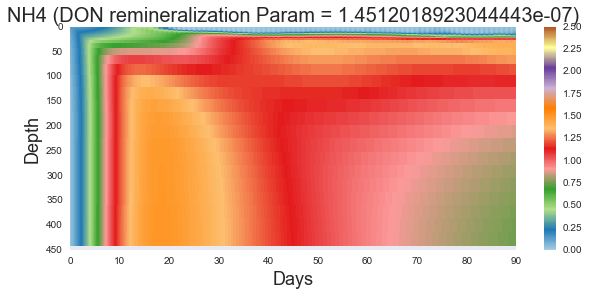

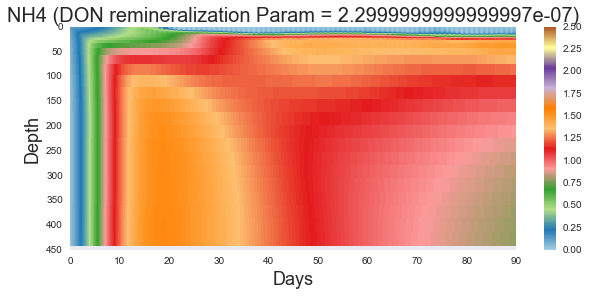

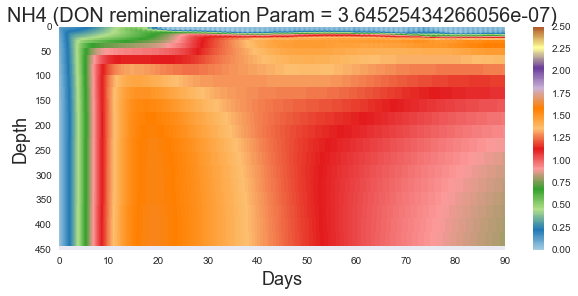

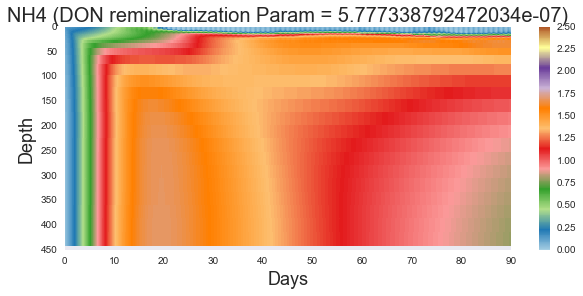

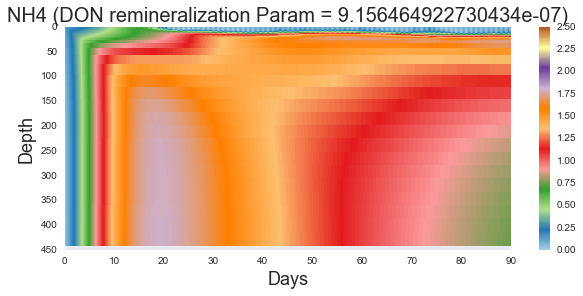

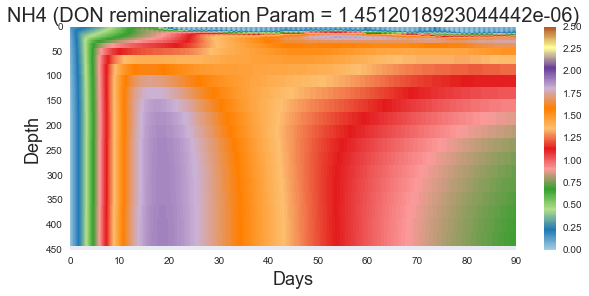

In [8]:
# Plot depth/time/NH4 heatmap for each value
for DON_remin_const in sorted(list(dataset_dict.keys())):
    z = dataset_dict[DON_remin_const].deptht.values
    t= np.array([float(x) for x in dataset_dict[DON_remin_const].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[DON_remin_const].NH4.values[:,:,2,2].T, vmin = 0, vmax = 2.5)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title("NH4 (DON remineralization Param = " + str(DON_remin_const)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

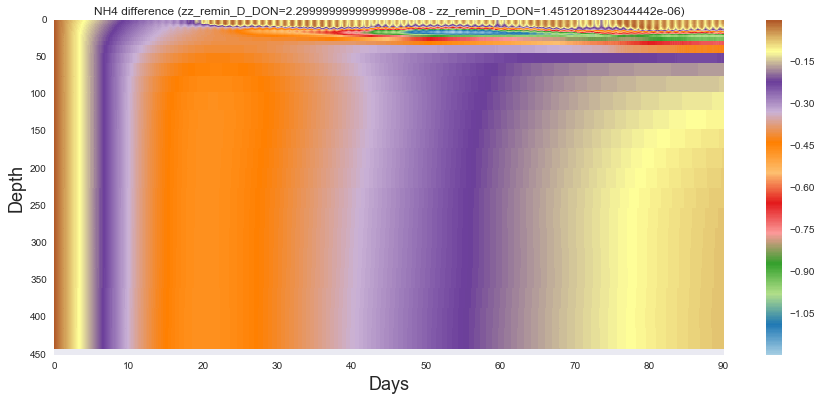

In [9]:
# Plot the difference in NH4 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1].NH4.values[:,:,2,2].T - dataset_dict[param_2].NH4.values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title("NH4 difference (zz_remin_D_DON=" + str(param_1) + " - zz_remin_D_DON=" +str(param_2)+ ")")

In [10]:
# Convert list of xarrays to a single pandas dataframe. Easier to manipulate and plot
dataframe_list = []
for DON_remin_const in dataset_dict:
    df = dataset_dict[DON_remin_const].to_dataframe().query('x == 2 and y == 2 and axis_nbounds == 0')
    df['DON_CONST'] = DON_remin_const
    dataframe_list.append(df)

df_subset = pd.concat(dataframe_list)

df_subset.reset_index(inplace=True) # Get rid of that multiindex madness

In [11]:
# Create a dataframe with depth averaged tracer values. If all grid heights are the same this is the mean value
mesh_mask = xr.open_dataset(group_results_directory + '/' + individual_directories[0] +'/' + 'mesh_mask.nc')

grid_heights = pd.DataFrame({'deptht': mesh_mask['gdept_1d'].values[0], 'GRID_HEIGHT' : mesh_mask['e3t_1d'].values[0]})


grid_heights = grid_heights.round({'deptht':3})
df_subset = df_subset.round({'deptht':3})

depth_averaged = df_subset.groupby(['time_counter','DON_CONST','x','y']).mean()
depth_averaged.reset_index(inplace=True)
df_subset = pd.merge(df_subset, grid_heights, on='deptht', how = "left")



In [12]:
grouped = df_subset.groupby(['time_counter','DON_CONST','x','y'])

def weighted(x, cols, w="deptht"):
             return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)

depth_summed = grouped.apply(weighted, plot_vars)



In [13]:
depth_averaged = df_subset.groupby(['time_counter','DON_CONST','x','y']).mean()
depth_averaged.reset_index(inplace=True)

In [14]:
(depth_summed).reset_index(inplace=True)

[   0.5      5.5     10.505   15.634   24.1     76.586  199.573  333.75 ]


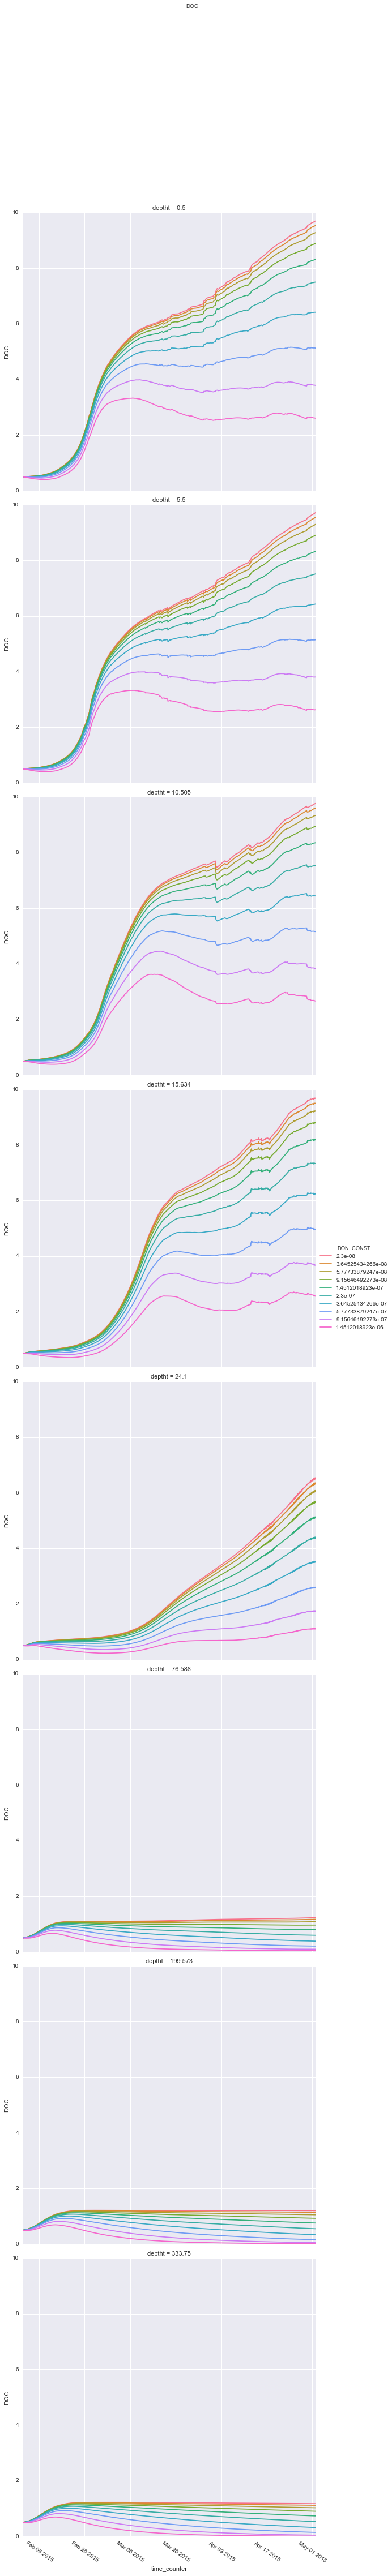

In [19]:
plot_vars = ['DOC']#[ 'DOC','MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi']



depth_vals = (df_subset['deptht'].unique())[0:40:5]

print(depth_vals)
for var in plot_vars:
    fg = sns.FacetGrid(data=df_subset.query("deptht in @depth_vals"), hue='DON_CONST',row = "deptht",size =8)
    fg.map(plt.plot, 'time_counter', var).add_legend()
    fg.set_xticklabels(rotation=-35)
    plt.subplots_adjust(top=0.9)
    fg.fig.suptitle(var)